In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Data Loading and Initial Exploration

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from datetime import datetime
from typing import Dict, Tuple, List, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, f1_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.inspection import permutation_importance

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")


# Create directories for outputs
os.makedirs('models', exist_ok=True)
os.makedirs('models/plots', exist_ok=True)

In [38]:
# Load the dataset
df = pd.read_csv('interview_dataset.csv')

# Initial exploration
print(f"Dataset shape: {df.shape}")
print(f"Data types:\n{df.dtypes.value_counts()}")
print(f"Missing values: {df.isnull().sum().sum()}")

Dataset shape: (500, 6905)
Data types:
float64    6213
object      346
int64       346
Name: count, dtype: int64
Missing values: 2808748


In [34]:
# Display basic information about the dataset
print("\nFirst few rows of the dataset:")
df.head()


First few rows of the dataset:


,SubmissionDate,starttime,endtime,version,duration,survey_start,intro_start,text_audit,date_collection,region,...,HH Production UGX,HH Income + Production UGX,Program Value UGX,Assets,HH Income UGX/Day,HH Production UGX/Day,HH Income + Production UGX/Day,Program Value UGX/Day,STATUS,HH Income + Production/Day (USD)
0,"Aug 6, 2024 3:52:21 PM","Aug 6, 2024 11:50:32 AM","Aug 6, 2024 12:44:45 PM",2408061513,3093,7.0,7.0,https://rtvuganda.surveycto.com/view/submissio...,2024-08-07 00:00:00,4,...,1825000.0,5253000.0,6148000.0,895000,9391.780822,5000.000000,14391.780822,16843.835616,RTV,3.889670
1,"Aug 1, 2024 5:44:43 PM","Aug 1, 2024 11:36:23 AM","Aug 1, 2024 12:13:08 PM",2407311236,2003,62.0,62.0,https://rtvuganda.surveycto.com/view/submissio...,2024-08-02 00:00:00,4,...,786000.0,1335000.0,1335000.0,0,1504.109589,2153.424658,3657.534247,3657.534247,RTV,0.988523
2,"Aug 3, 2024 12:34:58 AM","Aug 2, 2024 4:13:56 PM","Aug 2, 2024 5:02:05 PM",2408021241,2890,7.0,7.0,https://rtvuganda.surveycto.com/view/submissio...,2024-08-03 00:00:00,4,...,1955000.0,2385000.0,2535000.0,150000,1178.082192,5356.164384,6534.246575,6945.205479,RTV,1.766013
3,"Aug 6, 2024 9:17:47 PM","Aug 6, 2024 10:44:39 AM","Aug 6, 2024 12:10:57 PM",2408061513,5178,5.0,5.0,https://rtvuganda.surveycto.com/view/submissio...,2024-08-07 00:00:00,2,...,789000.0,3510500.0,6160500.0,2650000,7456.164384,2161.643836,9617.808219,16878.082192,RTV,2.599408
4,"Aug 1, 2024 1:39:03 PM","Aug 1, 2024 12:20:03 PM","Aug 1, 2024 1:27:07 PM",2407302157,4024,5.0,5.0,https://rtvuganda.surveycto.com/view/submissio...,2024-08-02,4,...,868350.0,2326350.0,3276350.0,950000,3994.520548,2379.041096,6373.561644,8976.301370,RTV,1.722584


In [35]:
print("\nDataset Information:")
df.info(verbose=False, show_counts=True)


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 6905 entries, SubmissionDate to HH Income + Production/Day (USD)
dtypes: float64(6213), int64(346), object(346)
memory usage: 26.3+ MB


In [36]:
# Summary statistics for numeric columns
print("\nSummary statistics for key numeric columns:")
numeric_cols = df.select_dtypes(include=['number']).columns
print(df[numeric_cols].describe().T)


Summary statistics for key numeric columns:
                                  count          mean            std  \
version                           500.0  2.407743e+09  366992.308890   
duration                          500.0  3.900824e+03    1209.003815   
survey_start                      500.0  1.743400e+01      84.928153   
intro_start                       500.0  1.744000e+01      84.927214   
region                            500.0  3.756000e+00       0.655227   
...                                 ...           ...            ...   
HH Income UGX/Day                 500.0  5.721690e+03    4433.592688   
 HH Production UGX/Day            500.0  3.496878e+03    2212.503873   
HH Income + Production UGX/Day    500.0  9.218567e+03    5644.896971   
Program Value UGX/Day             500.0  1.181293e+04    7210.975943   
HH Income + Production/Day (USD)  500.0  2.491505e+00       1.525648   

                                           min           25%           50%  \
version     

In [39]:
# Check for missing values in key columns
missing_vals = df.isnull().sum()
missing_vals_pct = (missing_vals / len(df)) * 100
print("\nColumns with missing values (top 20):")
missing_df = pd.DataFrame({
    'Missing Values': missing_vals,
    'Percentage': missing_vals_pct
})
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False).head(20))


Columns with missing values (top 20):
                                  Missing Values  Percentage
farming_inputsother_expenses                 500       100.0
business13_member2_days                      500       100.0
business12_member3_chosen                    500       100.0
business12_member3_days                      500       100.0
business12_profit_check                      500       100.0
business12_shocks_other                      500       100.0
business12_group_Amount                      500       100.0
business13_assets_check                      500       100.0
business13_stock_inventory_check             500       100.0
business13_stock_expenses_check              500       100.0
business13_expenses_check                    500       100.0
business13_member1_chosen                    500       100.0
hh_member2_bus13                             500       100.0
business13_member2_chosen                    500       100.0
hh_member3_bus13                             5

#2. Target Variable Analysis


Target Distribution:
At Risk (0): 211 (42.20%)
Not At Risk (1): 289 (57.80%)


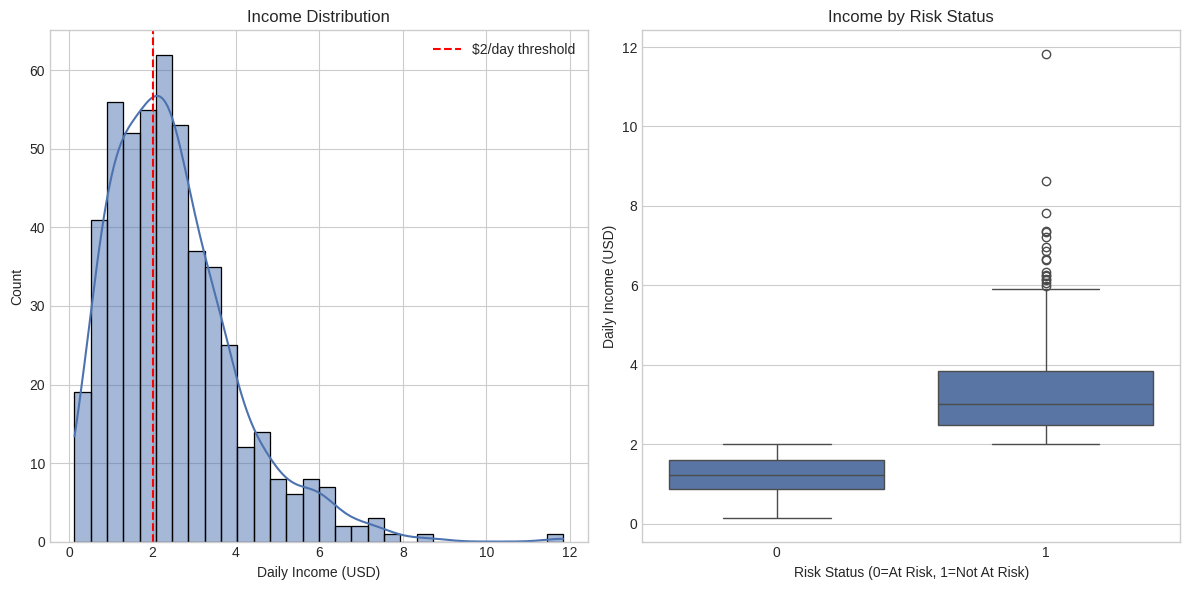


Income Statistics by Risk Group:
             count      mean       std       min       25%       50%  \
risk_status                                                            
0            211.0  1.221522  0.476180  0.130914  0.870381  1.216735   
1            289.0  3.418724  1.350257  2.002592  2.469456  3.013699   

                  75%        max  
risk_status                       
0            1.612181   1.994817  
1            3.851166  11.836357  


In [40]:
# Define target column and create binary target
target_column = 'HH Income + Production/Day (USD)'
risk_threshold = 2.0  # $2/day threshold as specified in requirements

# Create binary target: 0 = at risk (< $2/day), 1 = not at risk (>= $2/day)
df['risk_status'] = (df[target_column] >= risk_threshold).astype(int)

# Analyze target distribution
print("\nTarget Distribution:")
target_counts = df['risk_status'].value_counts()
target_pct = df['risk_status'].value_counts(normalize=True) * 100
print(f"At Risk (0): {target_counts.get(0, 0)} ({target_pct.get(0, 0):.2f}%)")
print(f"Not At Risk (1): {target_counts.get(1, 0)} ({target_pct.get(1, 0):.2f}%)")

# Visualize income distribution
plt.figure(figsize=(12, 6))

# Plot 1: Overall income distribution
plt.subplot(1, 2, 1)
sns.histplot(df[target_column], bins=30, kde=True)
plt.axvline(x=risk_threshold, color='red', linestyle='--', label=f'$2/day threshold')
plt.title('Income Distribution')
plt.xlabel('Daily Income (USD)')
plt.ylabel('Count')
plt.legend()

# Plot 2: Boxplot of income by risk status
plt.subplot(1, 2, 2)
sns.boxplot(x='risk_status', y=target_column, data=df)
plt.title('Income by Risk Status')
plt.xlabel('Risk Status (0=At Risk, 1=Not At Risk)')
plt.ylabel('Daily Income (USD)')

plt.tight_layout()
plt.savefig('models/plots/income_distribution.png')
plt.show()

# Calculate summary statistics by risk group
risk_group_stats = df.groupby('risk_status')[target_column].describe()
print("\nIncome Statistics by Risk Group:")
print(risk_group_stats)


:#3. Feature Selection and Engineering


Feature Groups:
Demographic: 6 features
Income sources: 5 features
Agriculture: 5 features
Assets: 4 features
Expenditure: 4 features
Created land_per_person feature
Created food_expense_per_person feature
Created crop_utilization_ratio feature
Created asset_index feature
Created education_factor feature
Created income_diversity feature
Created log-transformed feature for cereals_week
Created log-transformed feature for tubers_week
Created log-transformed feature for pulses_week
Created log-transformed feature for milk_week
Created log-transformed feature for Season1_land
Created log-transformed feature for Season2_land

Total features for modeling: 190
Skipping non-numeric feature for correlation: foodtime_month (type: object)

Using 189 numeric features for correlation analysis

Top 10 positively correlated features with risk status:
risk_status                               1.000000
business24_duration_year                  0.730564
sn_2_shamba_days_month                    0.59011

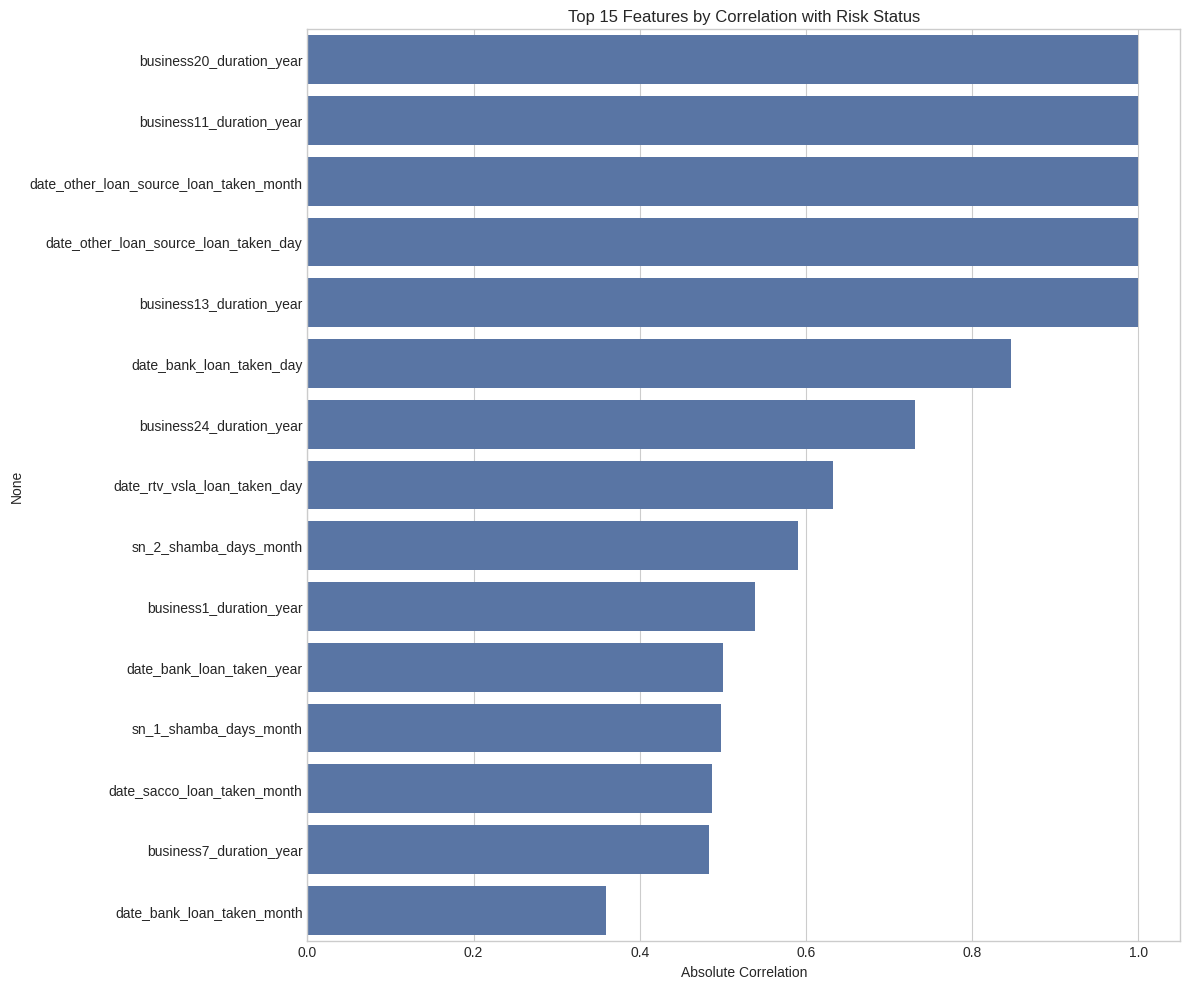

In [42]:
# Define feature groups based on domain knowledge
demographic_cols = [
    'hhh_sex', 'hhh_age', 'hhh_educ_level', 'hhh_read_write',
    'tot_hhmembers', 'hh_size_adjusted'
]

income_cols = [
    'business_number', 'work_salaried', 'work_casual',
    'borrowed_past_12_months', 'Rental_Income_Categories_1'
]

agriculture_cols = [
    'Season1_cropped', 'Season1_land', 'Season2_cropped', 'Season2_land',
    'livestock_present_hh'
]

asset_cols = [
    'farm_implements_owned', 'bicycle_owned', 'solar_owned', 'phones_owned'
]

expenditure_cols = [
    'cereals_week', 'tubers_week', 'pulses_week', 'milk_week'
]

# Deal with date columns first
date_cols = []
for col in df.columns:
    # Try to identify date columns
    if df[col].dtype == 'object':
        try:
            # Check if column contains dates by trying to convert a sample
            sample = df[col].dropna().iloc[0] if not df[col].dropna().empty else None
            if sample and isinstance(sample, str):
                if any(date_format in sample.lower() for date_format in ['am', 'pm', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']):
                    date_cols.append(col)
                    try:
                        # Try to convert to datetime
                        df[col] = pd.to_datetime(df[col], errors='coerce')
                        # Extract useful numeric features
                        df[f'{col}_year'] = df[col].dt.year
                        df[f'{col}_month'] = df[col].dt.month
                        df[f'{col}_day'] = df[col].dt.day
                        print(f"Converted date column '{col}' to numeric features")
                    except Exception as e:
                        print(f"Failed to convert date column '{col}': {str(e)}")
        except Exception:
            pass

# Filter columns to keep only those that exist in the dataset
demographic_cols = [col for col in demographic_cols if col in df.columns]
income_cols = [col for col in income_cols if col in df.columns]
agriculture_cols = [col for col in agriculture_cols if col in df.columns]
asset_cols = [col for col in asset_cols if col in df.columns]
expenditure_cols = [col for col in expenditure_cols if col in df.columns]

print("\nFeature Groups:")
print(f"Demographic: {len(demographic_cols)} features")
print(f"Income sources: {len(income_cols)} features")
print(f"Agriculture: {len(agriculture_cols)} features")
print(f"Assets: {len(asset_cols)} features")
print(f"Expenditure: {len(expenditure_cols)} features")

# Create additional engineered features based on domain knowledge

# Encode categorical variables (e.g., hhh_sex)
if 'hhh_sex' in df.columns and df['hhh_sex'].dtype == 'object':
    df['hhh_sex_encoded'] = df['hhh_sex'].map({'Male': 0, 'Female': 1})
    print("Encoded hhh_sex to numeric values")

# Land per person ratio
if 'Season1_land' in df.columns and 'tot_hhmembers' in df.columns:
    df['land_per_person'] = df['Season1_land'] / df['tot_hhmembers'].replace(0, 1)
    print("Created land_per_person feature")

# Food expense per person
if len(expenditure_cols) > 0 and 'tot_hhmembers' in df.columns:
    df['food_expense_per_person'] = df[expenditure_cols].sum(axis=1) / df['tot_hhmembers'].replace(0, 1)
    print("Created food_expense_per_person feature")

# Agricultural productivity
if 'Season1_cropped' in df.columns and 'Season1_land' in df.columns:
    df['crop_utilization_ratio'] = df['Season1_cropped'] / df['Season1_land'].replace(0, np.nan)
    df['crop_utilization_ratio'] = df['crop_utilization_ratio'].fillna(
        df['crop_utilization_ratio'].median() if not pd.isna(df['crop_utilization_ratio'].median()) else 0
    )
    print("Created crop_utilization_ratio feature")

# Asset index
if len(asset_cols) > 0:
    df['asset_index'] = df[asset_cols].fillna(0).sum(axis=1)
    print("Created asset_index feature")

# Education factor
if 'hhh_educ_level' in df.columns and 'hhh_read_write' in df.columns:
    df['education_factor'] = df['hhh_educ_level'] * df['hhh_read_write']
    print("Created education_factor feature")

# Income diversity
income_source_columns = [col for col in income_cols + ['livestock_present_hh']
                       if col in df.columns]
if len(income_source_columns) > 0:
    df['income_diversity'] = df[income_source_columns].replace(np.nan, 0).apply(
        lambda row: sum(row > 0), axis=1
    )
    print("Created income_diversity feature")

# Log transform for skewed numeric variables
skewed_cols = [col for col in expenditure_cols + ['Season1_land', 'Season2_land']
             if col in df.columns]

for col in skewed_cols:
    if col in df.columns and df[col].min() >= 0:  # Only transform non-negative columns
        df[f'{col}_log'] = np.log1p(df[col])
        print(f"Created log-transformed feature for {col}")

# Create a feature list combining existing and engineered features
# Base features
base_features = (
    demographic_cols +
    income_cols +
    agriculture_cols +
    asset_cols +
    expenditure_cols
)

# Add engineered features
engineered_features = [
    col for col in df.columns
    if (col.endswith('_encoded') or
        col.endswith('_log') or
        col in ['land_per_person', 'food_expense_per_person',
               'crop_utilization_ratio', 'asset_index',
               'education_factor', 'income_diversity'])
]

# Add date-derived features
date_features = [
    col for col in df.columns
    if col.endswith('_year') or col.endswith('_month') or col.endswith('_day')
]

# Combine all features
all_features = base_features + engineered_features + date_features
all_features = [f for f in all_features if f in df.columns and f != 'risk_status' and f != target_column]

print(f"\nTotal features for modeling: {len(all_features)}")

# Check feature correlation with target
# Filter only numeric features for correlation analysis
numeric_only_features = []
for feature in all_features:
    if pd.api.types.is_numeric_dtype(df[feature].dtype):
        numeric_only_features.append(feature)
    else:
        print(f"Skipping non-numeric feature for correlation: {feature} (type: {df[feature].dtype})")

print(f"\nUsing {len(numeric_only_features)} numeric features for correlation analysis")
corr_with_target = df[[*numeric_only_features, 'risk_status']].corr()['risk_status'].sort_values(ascending=False)
print("\nTop 10 positively correlated features with risk status:")
print(corr_with_target[:11])  # Including risk_status itself
print("\nTop 10 negatively correlated features with risk status:")
print(corr_with_target[-10:])

# Visualize top correlated features
plt.figure(figsize=(12, 10))
top_k = min(15, len(corr_with_target) - 1)  # Show top k features, but not more than what we have
corr_data = corr_with_target.drop('risk_status').abs().nlargest(top_k)
sns.barplot(x=corr_data.values, y=corr_data.index)
plt.title(f'Top {top_k} Features by Correlation with Risk Status')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.savefig('models/plots/feature_correlations.png')
plt.show()


#4. Data Preprocessing

In [43]:
# Handle missing values for numeric features
print("\nHandling missing values...")
X = df[all_features].copy()
y = df['risk_status']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Fit preprocessor on training data
print("Fitting preprocessor on training data...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training set: {X_train_processed.shape}")
print(f"Processed test set: {X_test_processed.shape}")


Handling missing values...
Numeric features: 189
Categorical features: 1
Training set: (375, 190)
Test set: (125, 190)
Fitting preprocessor on training data...
Processed training set: (375, 197)
Processed test set: (125, 197)


#5. Model Development


Training and evaluating multiple models...
Cross-validating LogisticRegression...
LogisticRegression ROC-AUC: 0.6904 (±0.0475)
Cross-validating RandomForest...
RandomForest ROC-AUC: 0.7012 (±0.0651)
Cross-validating GradientBoosting...
GradientBoosting ROC-AUC: 0.6944 (±0.0500)

Best model based on cross-validation: RandomForest

Optimal threshold: 0.50


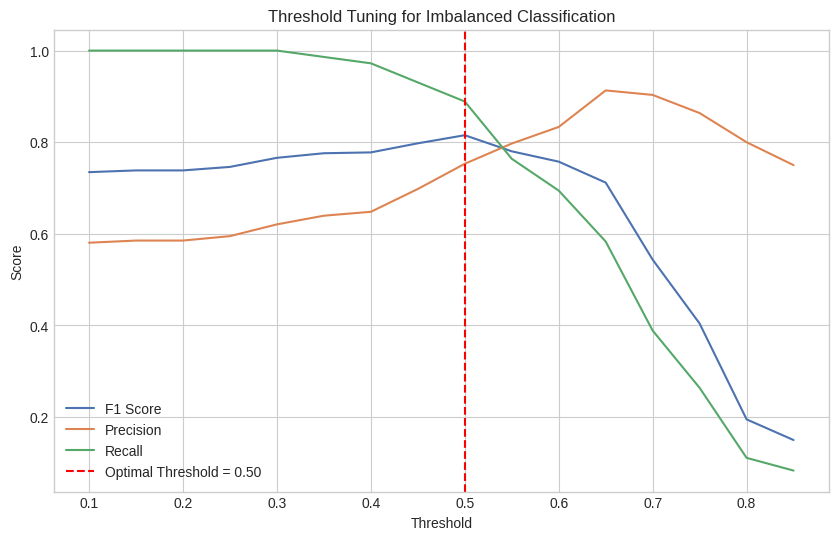

In [44]:
# Train and evaluate multiple models to compare performance
print("\nTraining and evaluating multiple models...")

# Define models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Compare models with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_scores = {}

for name, model in models.items():
    print(f"Cross-validating {name}...")
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='roc_auc')
    model_scores[name] = {
        'mean_cv_score': cv_scores.mean(),
        'std_cv_score': cv_scores.std()
    }
    print(f"{name} ROC-AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Select the best model based on cross-validation
best_model_name = max(model_scores, key=lambda k: model_scores[k]['mean_cv_score'])
print(f"\nBest model based on cross-validation: {best_model_name}")

# Train the best model on the full training set
best_model = models[best_model_name]
best_model.fit(X_train_processed, y_train)

# For RandomForest or GradientBoosting, we can look at feature importance
if best_model_name in ['RandomForest', 'GradientBoosting']:
    # Get feature names after preprocessing
    feature_names = []

    # For numeric features
    feature_names.extend(numeric_features)

    # For categorical features (after one-hot encoding)
    if categorical_features:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = ohe.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)

    # Get feature importances
    importances = best_model.feature_importances_

    # Create a DataFrame for visualization
    if len(feature_names) == len(importances):
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        # Visualize top features
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
        plt.title(f'Top 15 Most Important Features ({best_model_name})')
        plt.tight_layout()
        plt.savefig(f'models/plots/{best_model_name}_feature_importance.png')
        plt.show()

        print("\nTop 10 important features:")
        print(importance_df.head(10))
    else:
        print(f"Warning: Feature names ({len(feature_names)}) and importance scores ({len(importances)}) have different lengths")

# Tune the probability threshold for imbalanced classification
# Get predicted probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]

# Calculate F1 score for different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_threshold))
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))

# Find the threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nOptimal threshold: {optimal_threshold:.2f}")

# Visualize threshold tuning
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning for Imbalanced Classification')
plt.legend()
plt.grid(True)
plt.savefig('models/plots/threshold_tuning.png')
plt.show()

# Generate final predictions using the optimal threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

6. Evaluation


Model Evaluation:
ROC-AUC: 0.8236
Optimal Threshold: 0.50

Confusion Matrix:
[[32 21]
 [ 8 64]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        53
           1       0.75      0.89      0.82        72

    accuracy                           0.77       125
   macro avg       0.78      0.75      0.75       125
weighted avg       0.77      0.77      0.76       125



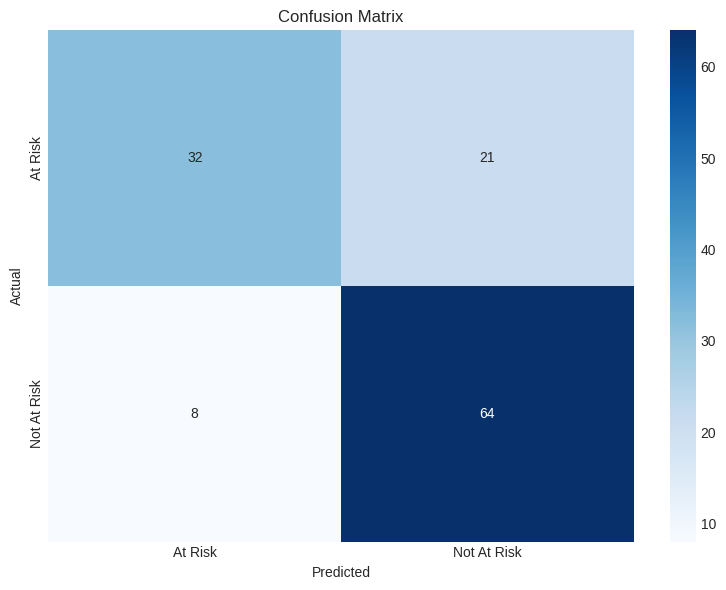

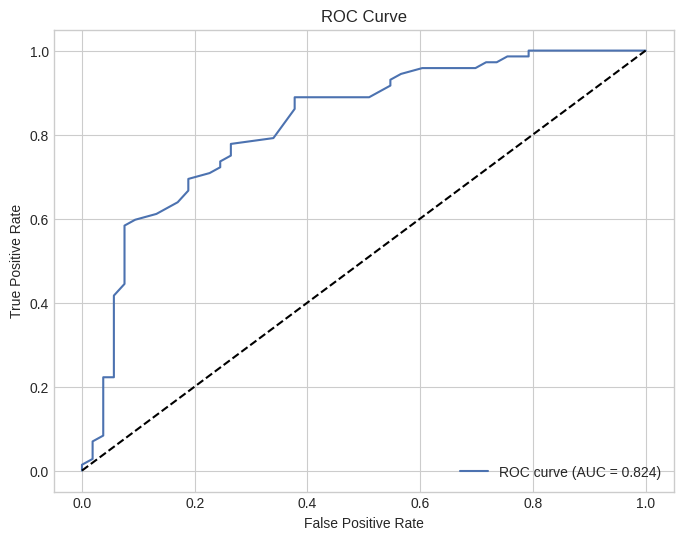

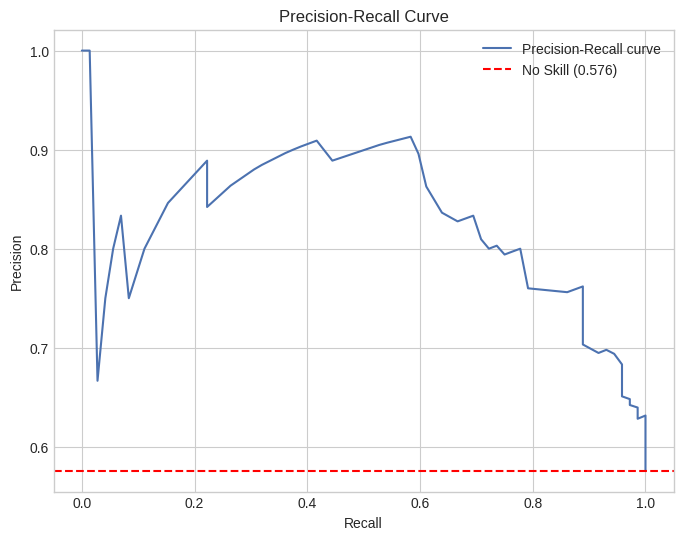

In [45]:
# Compute evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nModel Evaluation:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print("\nConfusion Matrix:")
print(conf_mat)
print("\nClassification Report:")
print(class_report)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=['At Risk', 'Not At Risk'],
           yticklabels=['At Risk', 'Not At Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('models/plots/confusion_matrix.png')
plt.show()

# ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('models/plots/roc_curve.png')
plt.show()

# Precision-Recall curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.axhline(y=sum(y_test)/len(y_test), color='r', linestyle='--',
            label=f'No Skill ({sum(y_test)/len(y_test):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.savefig('models/plots/precision_recall_curve.png')
plt.show()


Error Analysis:
error_type
Correct           96
False Positive    21
False Negative     8
Name: count, dtype: int64


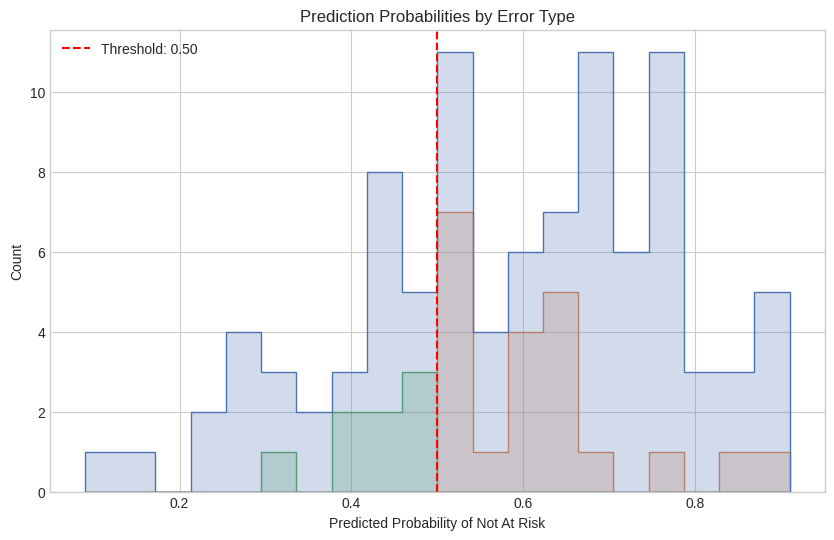

In [46]:
# Analyze misclassifications
errors_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'probability': y_pred_proba
})
errors_df['correct'] = errors_df['actual'] == errors_df['predicted']

errors_df['error_type'] = 'Correct'
errors_df.loc[(errors_df['actual'] == 1) & (errors_df['predicted'] == 0), 'error_type'] = 'False Negative'
errors_df.loc[(errors_df['actual'] == 0) & (errors_df['predicted'] == 1), 'error_type'] = 'False Positive'

print("\nError Analysis:")
print(errors_df['error_type'].value_counts())

# Visualize prediction probabilities by error type
plt.figure(figsize=(10, 6))
sns.histplot(data=errors_df, x='probability', hue='error_type', bins=20, element='step')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Threshold: {optimal_threshold:.2f}')
plt.title('Prediction Probabilities by Error Type')
plt.xlabel('Predicted Probability of Not At Risk')
plt.legend()
plt.savefig('models/plots/error_analysis.png')
plt.show()

# 7. Save Model

In [47]:
# Save the final model and preprocessor for production use
model_version = f"rtv_risk_model_v{datetime.now().strftime('%Y%m%d')}"
model_package = {
    'model': best_model,
    'preprocessor': preprocessor,
    'feature_names': all_features,
    'threshold': optimal_threshold,
    'train_date': datetime.now().strftime("%Y-%m-%d"),
    'model_version': model_version
}

model_path = os.path.join('models', f"{model_version}.joblib")
joblib.dump(model_package, model_path)
print(f"\nModel saved to {model_path}")


Model saved to models/rtv_risk_model_v20250227.joblib
